In [1]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 8
learning_rate = 0.0015
num_epochs = 800

normal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\normal'
abnormal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\abnormal'


In [3]:
normal_set = datasets.ImageFolder(
    normal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

abnormal_set = datasets.ImageFolder(
    abnormal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

train_dataset, test_dataset = torch.utils.data.random_split(normal_set, [220, 80])

In [4]:
def make_dir(args):    
    import os

    MODEL_DIR = f"FL_model/client = {args.num_clients}"
    try:
        os.makedirs(MODEL_DIR)
    except FileExistsError:
        print('Directories not created because they already exist')

In [5]:
def list_np_tensor(param_data):
    data = []
    for i in range(np.size(param_data, 0)):
        data.append(np.concatenate((param_data[i]['net.0.weight'].cpu().numpy(), np.expand_dims(param_data[i]['net.0.bias'].cpu().numpy(), axis=1)),axis=1))
    
    data = torch.Tensor(data)
    return data
    
def save_param(param_data):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    dtf = pd.DataFrame(dt)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def save_param_with_round(param_data, round_list, args):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    
    round_tensor = torch.tensor(round_list).view(-1, 1)
    dt_r = torch.cat((dt, round_tensor), dim=1)
    
    dtf = pd.DataFrame(dt_r)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def load_data(args):    
    ldt = pd.read_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    ldt = ldt.values
    ldt = np.delete(ldt, 0, 1)
    return ldt

def data_split(args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

In [6]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)      
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        
        return output

In [7]:
def define_client(partition, r, num, args):
    train_loader = DataLoader(partition['train'][num], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = ConvAutoEncoder().to(device)
    else:
        net = torch.load(args.INIT_PATH)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

In [8]:
def train(net, train_loader, criterion, optimizer, args):
    
    train_loss = 0
    for epoch in range(args.num_epochs):        
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
    train_loss /= len(train_loader)*args.num_epochs

    torch.save(net, args.NET_PATH)
    return net, train_loss

In [9]:
def Fed_AVG(model, client_model_list, args):
    model.train()
    local_weights = []

    for i in range(args.num_clients):
        local_weights.append(copy.deepcopy(client_model_list[i].state_dict()))
    w_avg = copy.deepcopy(local_weights[0]) #type of w_avg : <class 'collections.OrderedDict'>

    for key in w_avg.keys():
        for i in range(1,len(local_weights)):
            w_avg[key] += local_weights[i][key]
        w_avg[key] = torch.div(w_avg[key], len(local_weights))

    global_weights = w_avg
    model.load_state_dict(global_weights)
    torch.save(model, args.INIT_PATH)

    return model, local_weights

In [10]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition['test'], batch_size=args.batch_size, shuffle=True)
    model.eval()

    loss = 0
    round_loss = 0
            
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)
        loss += criterion(outputs, images).item()
    
    round_loss = loss / len(test_loader)
 
    return round_loss

In [11]:
def experiment(partition, args):
    model = ConvAutoEncoder().to(device)
    torch.save(model, args.INIT_PATH)

    round_losses = []
    round_client_losses = []
    param_data = []
    round_list = []

    for r in range(args.num_rounds):
        train_losses = []
        client_model_list = []
        
        for num in range(args.num_clients):
            setattr(args, 'NET_PATH', f'FL_model/client = {args.num_clients}/client_{num}.pth')
            
            net, train_loader, criterion, optimizer = define_client(partition, r, num, args)
            net, train_loss = train(net, train_loader, criterion, optimizer, args)
            
            client_model_list.append(net)
            train_losses.append(train_loss)
            
        model, local_weights = Fed_AVG(model, client_model_list, args)
        round_loss = test(model, partition, criterion, args)

        print(f'[Round {r}] Round Loss: {round_loss:.4f} Client1 Loss: {train_losses[0]:.4f} Client2 Loss: {train_losses[1]:.4f}')

        round_losses.append(round_loss)
        round_client_losses.append(train_losses)
        round_list.append([r, r, r])
        param_data += local_weights
        
    return round_losses, round_client_losses, round_list, param_data

In [12]:
def plot_loss(round_loss, round_client_losses):
    plt.plot(round_loss, label='Avg')
    plt.plot(np.array(round_client_losses)[:,0], label='Client1')
    plt.plot(np.array(round_client_losses)[:,1], label='Client2')
    plt.grid()
    plt.legend()

    plt.show()

[Round 0] Round Loss: 0.0482 Client1 Loss: 0.0590 Client2 Loss: 0.0401
[Round 1] Round Loss: 0.0476 Client1 Loss: 0.0481 Client2 Loss: 0.0483
[Round 2] Round Loss: 0.0470 Client1 Loss: 0.0474 Client2 Loss: 0.0475
[Round 3] Round Loss: 0.0464 Client1 Loss: 0.0469 Client2 Loss: 0.0469
[Round 4] Round Loss: 0.0455 Client1 Loss: 0.0462 Client2 Loss: 0.0465
[Round 5] Round Loss: 0.0445 Client1 Loss: 0.0450 Client2 Loss: 0.0453
[Round 6] Round Loss: 0.0431 Client1 Loss: 0.0440 Client2 Loss: 0.0444
[Round 7] Round Loss: 0.0416 Client1 Loss: 0.0424 Client2 Loss: 0.0426
[Round 8] Round Loss: 0.0398 Client1 Loss: 0.0409 Client2 Loss: 0.0411
[Round 9] Round Loss: 0.0377 Client1 Loss: 0.0390 Client2 Loss: 0.0392
[Round 10] Round Loss: 0.0355 Client1 Loss: 0.0370 Client2 Loss: 0.0373
[Round 11] Round Loss: 0.0332 Client1 Loss: 0.0345 Client2 Loss: 0.0346
[Round 12] Round Loss: 0.0309 Client1 Loss: 0.0324 Client2 Loss: 0.0326
[Round 13] Round Loss: 0.0287 Client1 Loss: 0.0300 Client2 Loss: 0.0301
[R

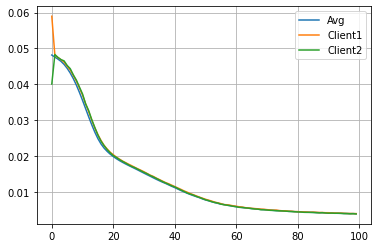

In [13]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.num_epochs = 5
args.num_rounds = 100
args.num_clients = 2
args.lr = 0.0001

args.batch_size = 100

make_dir(args)

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'

train_set_list = data_split(args)
partition = {'train':train_set_list, 'test':test_dataset}
    
round_loss, round_client_losses, round_list, param_data = experiment(partition, args)
plot_loss(round_loss, round_client_losses)